<a href="https://colab.research.google.com/github/oktaviacitra/classification/blob/main/VillainClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive

origin_path = "/content/drive"
drive.mount(origin_path)

folder_path = origin_path + "/MyDrive/Learning Journey/Villain Data/"

Mounted at /content/drive


In [2]:
class_labels = ["Vader", "Green Goblin", "Joker", "Thanos", "Venom"]
image_files = [ (folder_path + label + "/" + label + " " + str(i) + ".jpg") for i in range(1, 21) for label in class_labels]
len(image_files)

100

In [3]:
import tensorflow
import numpy as np
from PIL import Image
from tensorflow.keras.preprocessing import image

def preprocessing_image(path, target):
    img = Image.open(path)

    # crop central
    width, height = img.size
    new_width = new_height = width
    left = (width - new_width)/2
    top = (height - new_height)/2
    right = (width + new_width)/2
    bottom = (height + new_height)/2
    img = img.crop((left, top, right, bottom))

    # convert to array of rgb
    img = img.resize(target)
    img = img.convert('RGB')
    x = image.img_to_array(img)
    x = x[:, :, :3]
    x = np.true_divide(x, 255)
    return x

In [4]:
from sklearn.preprocessing import LabelEncoder

X = np.asarray([preprocessing_image(image_file, (64,64)) for image_file in image_files])

y = [ label for i in range(1, 21) for label in class_labels]
le = LabelEncoder()
le.fit(y)
y = le.transform(y)


X.shape, y.shape

((100, 64, 64, 3), (100,))

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)
X_train.shape, X_test.shape, X_val.shape

((70, 64, 64, 3), (15, 64, 64, 3), (15, 64, 64, 3))

In [6]:
!pip install -q -U keras-tuner

     |████████████████████████████████| 135 kB 32.5 MB/s 


In [7]:
from tensorflow.keras import Input, Model, regularizers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, BatchNormalization, Activation, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD

def model_builder(hp):
  inputs = Input(shape=(64, 64, 3))
  x = Conv2D(filters = hp.Int('filters', min_value=64, max_value=1024, step = 32),
             kernel_size = hp.Int('kernel_size', 3, 5),
             padding="same",
             activation='relu',
             dilation_rate=2,
             kernel_initializer = "he_normal",
             kernel_regularizer=regularizers.l2(0.001),
             name="conv2d")(inputs)

  if hp.Choice('pooling', ['max', 'avg']) == 'max':
    x = MaxPooling2D(name="maxpool2d")(x)
  else:
    x = AveragePooling2D(name="averagepool2d")(x)

  x = BatchNormalization(name="batchnorm")(x)
  x = Dropout(0.1, name="dropout")(x)
  x = Flatten(name="flatten")(x)
  
  x = Dense(units=hp.Int('units_1', min_value=64, max_value=256, step=16),
            activation='relu',
            name='fully_connected')(x)
  outputs = Dense(5, activation='softmax', name='prediction')(x)

  model = Model(inputs=inputs, outputs=outputs)

  learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
  optimizer = Adam(learning_rate=learning_rate) if hp.Choice('optimizer', ['adam', 'sgd']) == 'adam' else SGD(learning_rate=learning_rate)
  
  model.compile(optimizer=optimizer,
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

  return model

In [8]:
import keras_tuner as kt

tuner = kt.Hyperband(hypermodel = model_builder,
                             objective = 'val_loss',
                             max_epochs = 10,
                             factor = 3,
                             directory = folder_path + '/results_dir',
                             project_name = 'villain')
tuner.search_space_summary()

Search space summary
Default search space size: 6
filters (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 1024, 'step': 32, 'sampling': None}
kernel_size (Int)
{'default': None, 'conditions': [], 'min_value': 3, 'max_value': 5, 'step': 1, 'sampling': None}
pooling (Choice)
{'default': 'max', 'conditions': [], 'values': ['max', 'avg'], 'ordered': False}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 256, 'step': 16, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}
optimizer (Choice)
{'default': 'adam', 'conditions': [], 'values': ['adam', 'sgd'], 'ordered': False}


In [9]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

best_weight = ModelCheckpoint(folder_path + "tuner/{epoch:02d}-{val_loss:.4f}.h5",
                              monitor="val_loss",
                              mode="min",
                              save_best_only=True,
                              verbose=1)
stop_early = EarlyStopping(monitor='val_loss', patience=5)

tuner.search(X_train, y_train, epochs=5,
             validation_data=(X_val, y_val),
             callbacks=[stop_early, best_weight],
             verbose=2)

Trial 4 Complete [00h 00m 04s]
val_loss: 2.209801197052002

Best val_loss So Far: 2.209801197052002
Total elapsed time: 00h 01m 01s

Search: Running Trial #5

Value             |Best Value So Far |Hyperparameter
800               |288               |filters
5                 |3                 |kernel_size
avg               |avg               |pooling
208               |112               |units_1
0.01              |0.0001            |learning_rate
adam              |sgd               |optimizer
2                 |2                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
2                 |2                 |tuner/bracket
0                 |0                 |tuner/round

Epoch 1/2

Epoch 1: val_loss improved from inf to 962.63501, saving model to /content/drive/MyDrive/Learning Journey/Villain Data/tuner/01-962.6350.h5
3/3 - 23s - loss: 2600.5991 - accuracy: 0.1857 - val_loss: 962.6350 - val_accuracy: 0.1333 - 23s/epoch - 8s/step
Epoch 2/2

Epoch 2: val_

KeyboardInterrupt: ignored

In [10]:
from tensorflow.keras.models import load_model

model = load_model(folder_path + "tuner/02-2.2098.h5")
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 288)       8064      
                                                                 
 averagepool2d (AveragePooli  (None, 32, 32, 288)      0         
 ng2D)                                                           
                                                                 
 batchnorm (BatchNormalizati  (None, 32, 32, 288)      1152      
 on)                                                             
                                                                 
 dropout (Dropout)           (None, 32, 32, 288)       0         
                                                                 
 flatten (Flatten)           (None, 294912)            0     

In [11]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

callbacks = [EarlyStopping(monitor="val_loss", patience=3, verbose=1),
             ReduceLROnPlateau(monitor = 'val_loss', factor=0.1, patience=2, verbose=1),
             ModelCheckpoint(folder_path + "tuner/{epoch:02d}-{val_loss:.4f}.h5", monitor="val_loss", mode="min", save_best_only=True, verbose=1)]
history = model.fit(X_train, y_train, epochs=200,
                    validation_data=(X_val, y_val), verbose=1,
                    callbacks=callbacks)

Epoch 1/200
3/3 [==============================] - ETA: 0s - loss: 1.7774 - accuracy: 0.5857WARNING:tensorflow:6 out of the last 11 calls to <function Model.make_test_function.<locals>.test_function at 0x7f50a62f99e0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.

Epoch 1: val_loss improved from inf to 2.27633, saving model to /content/drive/MyDrive/Learning Journey/Villain Data/tuner/01-2.2763.h5
3/3 [==============================] - 1

In [12]:
import matplotlib.pyplot as plt

def graph_history(title, subtitle, interval):
    plt.plot(history.history[title], label = title)
    plt.plot(history.history[subtitle], label = subtitle)
    plt.xlabel('Epoch')
    plt.ylabel(title)
    plt.ylim(interval)
    plt.legend(loc='lower right')

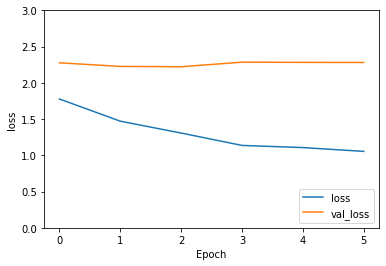

In [13]:
graph_history('loss', 'val_loss', [0.0, 3.0])

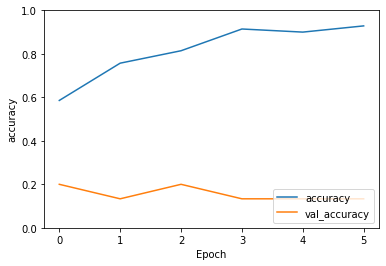

In [14]:
graph_history('accuracy', 'val_accuracy', [0.0, 1.0])

In [16]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

y_pred = model.predict(X_test)
print('accuracy : %.4f' % (accuracy_score(y_test, y_pred)) )
print('precision : %.4f' % (precision_score(y_test, y_pred, average='macro')) )
print('recall : %.4f' % (recall_score(y_test, y_pred, average='macro')) )
print('f1 : %.4f' % (f1_score(y_test, y_pred, average='macro')) )

ValueError: ignored

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()